## Isochrone Fitting for Quinn's Photometry

In [1]:
import numpy as np
import pandas as pd
import astropy.io.fits as pf
from astropy.table import Table
import matplotlib.pyplot as plt
import photutils as ph
import astropy.units as u
import astropy.constants as c
import glob
import os

In [2]:
# read in quinn's photometry

photomet = glob.glob('/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/*.csv')


In [4]:
photom = {}
photom_err = {}
for i,file in enumerate(photomet):
    if 'err' in file:
        dwarf = os.path.splitext(os.path.basename(file))[0][:-4]
        photom_err[dwarf] = pd.read_csv(file)
    else:
        dwarf = os.path.splitext(os.path.basename(file))[0][:-5]
        photom[dwarf] = pd.read_csv(file)

In [5]:
def read_dsep(filename, dm):

    dsep_txt = np.genfromtxt(filename, dtype=float, comments='#', unpack=True)
    dsep_g = dsep_txt[10]
    dsep_r = dsep_txt[15]

    dsep = pd.DataFrame({'g':dsep_g, 'r':dsep_r})
    dsep['gr'] = dsep['g'] - dsep['r']
    dsep['y'] = dsep['r'] + dm

    return dsep

In [6]:
5*np.log10(0.1e6) - 5

20.0

In [7]:
isochrones = {}

isos = glob.glob('/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/isochrones/DSEP/10-12Gyr/*5.iso')

for i,iso in enumerate(isos):
    file = os.path.splitext(os.path.basename(iso))[0]
    for dmod in np.linspace(20,21,3):
        dseps = read_dsep(iso,dmod)
        isochrones[file+str(dmod)]=dseps

In [8]:
isochrones.keys()

dict_keys(['12Gyr-1520.0', '12Gyr-1520.5', '12Gyr-1521.0', '11gyr-1520.0', '11gyr-1520.5', '11gyr-1521.0', '12gyr-12520.0', '12gyr-12520.5', '12gyr-12521.0', '10gyr-1520.0', '10gyr-1520.5', '10gyr-1521.0'])

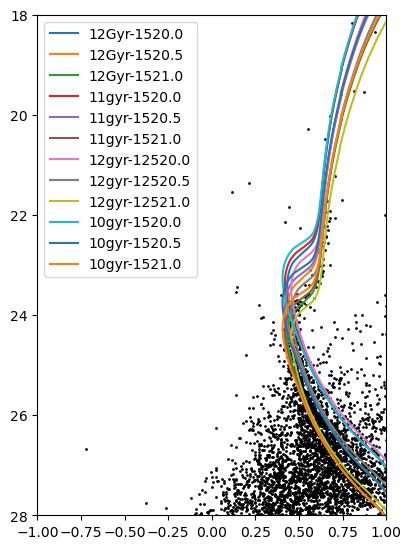

In [9]:
plt.figure(figsize=(4.5,6.5))

for iso in isochrones.keys():
    plt.plot(isochrones[iso]['gr'],isochrones[iso]['y'],label=iso)


plt.scatter(photom['leo']['color'],photom['leo']['f814w'],1,color='k')
plt.legend()
plt.xlim(-1,1)
plt.ylim(18,28)
plt.gca().invert_yaxis()


In [49]:
from scipy.spatial import cKDTree

def chi2_match(obs_data, isochrone, mag_err=0.05, color_err=0.05):
    """
    compute the chi^2 between observed stars and an isochrone.
    For each observed star, finds the closest point on the isochrone in CMD space.
    """
    # use a KDTree for distances
    tree = cKDTree(isochrone[['gr', 'y']].values)

    # find nearest isochrone point
    # make sure to remove nans and infs
    dists, idxs = tree.query(obs_data[['color', 'f814w']].dropna())

    # compute chi^2
    chi2 = np.sum((dists ** 2) / (mag_err**2 + color_err**2))
    return chi2

def find_best_isochrone(obs_data, isochrones, mag_err, color_err):
    """
    Return best fit isochrone
    """
    chi2_values = []

    for i, iso in enumerate(isochrones.keys()):
        chi2 = chi2_match(obs_data, isochrones[iso], mag_err, color_err)
        chi2_values.append(chi2)

    best_index = np.argmin(chi2_values)
    return best_index, chi2_values[best_index]

In [50]:
find_best_isochrone(photom['leo'],isochrones,mag_err=0,color_err=np.mean(photom_err['leo']))

(2, 99.7920853815279)

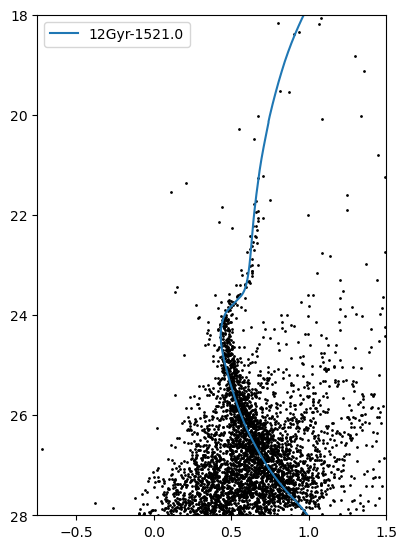

In [52]:
plt.figure(figsize=(4.5,6.5))
iso = list(isochrones.keys())
plt.plot(isochrones[iso[2]]['gr'],isochrones[iso[2]]['y'],label=iso[2])


plt.scatter(photom['leo']['color'],photom['leo']['f814w'],1,color='k')
plt.legend()
plt.xlim(-0.75,1.5)
plt.ylim(18,28)
plt.gca().invert_yaxis()